In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [2]:
from tensorflow.keras.applications import VGG16

# VGG16은 Convolution Layer 16개, Fc Layer는 3개로 구성된 Network

base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './data/cat_dog_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1/255)
batch_size=20

def extract_feature(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count,))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')

    i = 0

    for x_data_batch, t_data_batch in generator:
        feature_batch = base_model.predict(x_data_batch)
        features[i*batch_size:(i+1)*batch_size] = feature_batch
        labels[i*batch_size:(i+1)*batch_size] = t_data_batch
        
        i += 1
        if i * batch_size >= sample_count:
            break;
    
    return features, labels

train_features, train_labels = extract_feature(train_dir,2000)
validation_features, validation_labels = extract_feature(validation_dir,1000)
test_features, test_labels = extract_feature(test_dir,1000)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (2000,4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000,4 * 4 * 512))
test_features = np.reshape(test_features, (1000,4 * 4 * 512))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(256,
                activation='relu',
                input_shape=(4 * 4 * 512,)))
model.add(Dropout(0.5))
model.add(Dense(1,
                activation='sigmoid'))

model.compile(optimizer=RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features,
                    train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels)) 


Epoch 1/30
100/100 [==============================] - 1s 7ms/step - loss: 0.5989 - accuracy: 0.6735 - val_loss: 0.4337 - val_accuracy: 0.8560
Epoch 2/30
100/100 [==============================] - 1s 5ms/step - loss: 0.4205 - accuracy: 0.8045 - val_loss: 0.3607 - val_accuracy: 0.8750
Epoch 3/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3462 - accuracy: 0.8575 - val_loss: 0.3227 - val_accuracy: 0.8670
Epoch 4/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3119 - accuracy: 0.8685 - val_loss: 0.3070 - val_accuracy: 0.8750
Epoch 5/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2818 - accuracy: 0.8870 - val_loss: 0.2782 - val_accuracy: 0.8890
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2661 - accuracy: 0.8905 - val_loss: 0.2685 - val_accuracy: 0.8950
Epoch 7/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2482 - accuracy: 0.9075 - val_loss: 0.2609 - val_accuracy: 0.8960
Epoch 

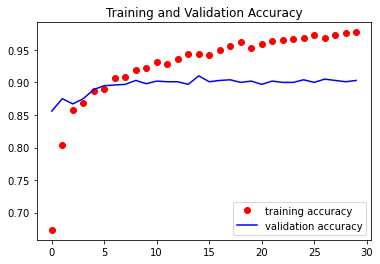

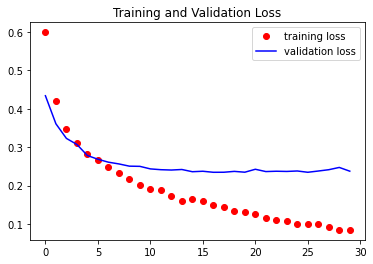

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, 'bo', color='r', label='training accuracy')
plt.plot(val_acc, 'b', color='b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, 'bo', color='r', label='training loss')
plt.plot(val_loss, 'b', color='b', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
____________________

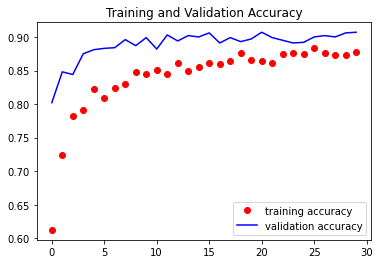

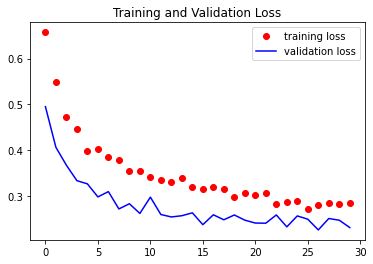

In [2]:
%reset
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt


train_dir = './data/cat_dog_small/train'
validation_dir = './data/cat_dog_small/validation'


# 모든 이미지 데이터의 값을 1/255로 scaling 하면서 augmentation
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Validation data에 대해서는 당연히 증식을 사용하면 안된다.
validation_datagen = ImageDataGenerator(rescale=1/255)


train_generator = train_datagen.flow_from_directory(
    train_dir,                    # target directory
    classes=['cats', 'dogs'],     # cats, dogs 순서로 label 0,1
                                  # (생략하면 폴더순서로 label적용)
    target_size=(150,150),        # image size scaling
    batch_size=20,                # 한번에 20개의 이미지를 가져온다. 
                                  # label에 상관없이 가져온다.
    class_mode='binary')          # 고양이와 멍멍이만 존재하므로 
                                  # 2진 분류이기 때문에 binary
                                  # 다중분류인 경우 'categorical'(기본값), 
                                  # 'sparse' 이용가능
                                  # 오토인코더처럼 입력을 target으로 하는 경우 'input'
                     
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')


## Pretrained Network
with tf.device('/device:GPU:1'):

    model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(150,150,3))

    model_base.trainable = False  # Convolution Layer 동결

    model = Sequential()

    model.add(model_base)

    model.add(Flatten(input_shape=(4*4*512,)))

    model.add(Dense(256,
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                    activation='sigmoid'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=2e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch=100,
                        epochs=30,
                        validation_data=validation_generator,
                        validation_steps=50,
                        verbose=2)


train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, 'bo', color='r', label='training accuracy')
plt.plot(val_acc, 'b', color='b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, 'bo', color='r', label='training loss')
plt.plot(val_loss, 'b', color='b', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
%reset
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt


train_dir = './data/cat_dog_small/train'
validation_dir = './data/cat_dog_small/validation'


# 모든 이미지 데이터의 값을 1/255로 scaling 하면서 augmentation
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Validation data에 대해서는 당연히 증식을 사용하면 안된다.
validation_datagen = ImageDataGenerator(rescale=1/255)


train_generator = train_datagen.flow_from_directory(
    train_dir,                    # target directory
    classes=['cats', 'dogs'],     # cats, dogs 순서로 label 0,1
                                  # (생략하면 폴더순서로 label적용)
    target_size=(150,150),        # image size scaling
    batch_size=20,                # 한번에 20개의 이미지를 가져온다. 
                                  # label에 상관없이 가져온다.
    class_mode='binary')          # 고양이와 멍멍이만 존재하므로 
                                  # 2진 분류이기 때문에 binary
                                  # 다중분류인 경우 'categorical'(기본값), 
                                  # 'sparse' 이용가능
                                  # 오토인코더처럼 입력을 target으로 하는 경우 'input'
                     
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')


with tf.device('/device:GPU:1'):
## Pretrained Network
    model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(150,150,3))

    model_base.trainable = False  # Convolution Layer 완전 동결

    model = Sequential()

    model.add(model_base)

    model.add(Flatten(input_shape=(4*4*512,)))

    model.add(Dense(256,
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                    activation='sigmoid'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=2e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch=100,
                        epochs=30,
                        validation_data=validation_generator,
                        validation_steps=50,
                        verbose=2)

    ### 여기까지가 아래의 작업 처리입니다.

    # Pretrained Network 위에 새로운 Network을 추가합니다.
    # Base Network을 동결합니다.
    # 새로 추가한 Network을 학습합니다.


    ### 아래의 작업이 추가로 필요합니다.
    # Base Network에서 일부 Layer의 동결을 해제합니다.
    # 동결을 해제한 층과 새로 추가한 층을 함께 학습합니다.

    model_base.trainable = True

    for layer in model_base.layers:
        if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
            layer.trainable = True
        else:    
            layer.trainable = False

    ## learning rate를 줄이는게 일반적(미세조절)        
    model.compile(optimizer=RMSprop(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    ## 재학습 진행
    history = model.fit(train_generator,
                        steps_per_epoch=100,
                        epochs=30,
                        validation_data=validation_generator,
                        validation_steps=50,
                        verbose=2)
        

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, 'bo', color='r', label='training accuracy')
plt.plot(val_acc, 'b', color='b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, 'bo', color='r', label='training loss')
plt.plot(val_loss, 'b', color='b', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
__________________